# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf

%matplotlib inline

In [2]:
# Get data_set using the utility method
dataSet = get_dataset("data/train/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['data/train/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['data/train/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 86
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


## Write a function to display an image and the bounding boxes

Implement the `display_images` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

tf.Tensor([0.52476245 0.27845883 0.5647303  0.312341  ], shape=(4,), dtype=float32)


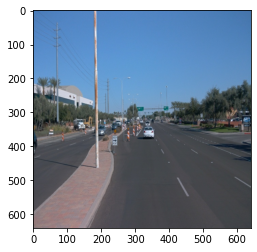

Hello World2!
Image  1
Blub


In [7]:
# Access data inside the data_set by iterating over the data_set
counter = 0

for data in dataSet:
    # Save bounding box of current element in local variable
    gtBoxes = data["groundtruth_boxes"]
    
    # Save labels in local variable
    gtClasses = data["groundtruth_classes"]
    
    
    if counter == 0:
        print(gtBoxes[0])
        display_images(data)
        break
    #counter += 1

print("Hello World2!")

def plot_images(dataSet, numImages):
    # Handle invalid input
    totalImages = np.max(1, numImages)
    
    for index, data in enumerate(dataSet):
        currentImgNumber = index + 1
        print("Image ", currentImgNumber)
        
        if (totalImages == currentImgNumber):
            break



plot_images(dataSet, 0)



In [3]:
def display_images(batch):
    # TODO - Your implementation here
    
    # Store image in local variable
    image = batch["image"]
    #print(image)
    
    # Display image
    plt.imshow(image)
    plt.show()
    
    pass

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

In [ ]:
# Display 10 random images in dataset

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...